###Set up

First, install all necessary packages and conncet to Flapjack


In [3]:
pip install pyflapjack --quiet

In [4]:
pip install loica --quiet

In [5]:
pip install sbol3 --quiet

In [6]:
pip install sbol_utilities --quiet

In [7]:
from flapjack import *
import loica as lc
import sbol3
from sbol_utilities import component

import numpy as np
import getpass
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
user = input()
passwd = getpass.getpass()
fj = Flapjack('flapjack.rudge-lab.org:8000')
fj.log_in(username=user, password=passwd)

LuizaKonkina
··········


###Flapjack connection


In [9]:
dna = fj.get('dna', name='Extended repressilator 1')
if len(dna)==0:
    dna = fj.create('dna', name='Extended repressilator 1')
vector = fj.get('vector', name='Ext_rep_1_plasmid')    
if len(vector)==0:
    vector = fj.create('vector', name='Ext_rep_1_plasmid', dnas=dna.id)   
study = fj.get('study', name='Luiza"s project')
if len(study)==0:
    study = fj.create('study', name='Luiza"s project', description='Testing circuits')
media = fj.get('media', name='Loica LB')
if len(media)==0:
    media = fj.create('media', name='Loica LB', description='Simulated loica media')
strain = fj.get('strain', name='Loica strain')
if len(strain)==0:
    strain = fj.create('strain', name='Loica strain', description='Loica test strain')

# Signals - reporter proteins
cfps = fj.get('signal', name='CFP')
if len(cfps)==0:
    cfps = fj.create('signal', name='CFP', color='cyan', description='Simulated cyan fluorescent protein')
yfps = fj.get('signal', name='YFP')
if len(yfps)==0:
    yfps = fj.create('signal', name='YFP', color='yellow', description='Simulated yellow fluorescent protein')
rfps = fj.get('signal', name='RFP')
if len(rfps)==0:
    rfps = fj.create('signal', name='RFP', color='red', description='Simulated red fluorescent protein')

biomass_signal = fj.get('signal', name='OD')

def growth_rate(t):
    return gompertz_growth_rate(t, 0.01, 1, 1, 1)

def biomass(t):
    return gompertz(t, 0.01, 1, 1, 1)

###Genetic network design

In [10]:
ext_rep = lc.GeneticNetwork(vector=vector.id[0])

####Regulators


In [11]:
# Transcription factors
laci_reg = lc.Regulator(name='LacI', degradation_rate=1, init_concentration=5)
tetr_reg = lc.Regulator(name='TetR', degradation_rate=1)
ci_reg = lc.Regulator(name='cI', degradation_rate=1)

# Signalling molecules
c4_reg = lc.Regulator(name='C4', degradation_rate=1)
scb2_reg = lc.Regulator(name='SCB2', degradation_rate=1)
c14_reg = lc.Regulator(name='C14', degradation_rate=1)

ext_rep.add_regulator([tetr_reg, laci_reg, ci_reg, c4_reg, scb2_reg, c14_reg])

####Reporters

In [12]:
mcherry_rep = lc.Reporter(name='mCherry', degradation_rate=1, signal_id=rfps.id[0], color='red')
cyan_rep = lc.Reporter(name='CFP', degradation_rate=1, signal_id=cfps.id[0], color='blue')
mven_rep = lc.Reporter(name='mVenus', degradation_rate=1, signal_id=yfps.id[0], color='yellow')

ext_rep.add_reporter([mcherry_rep, cyan_rep, mven_rep])

####Operators

In [13]:
#First "strain"
c4_laci = lc.Hill1(name='Prhl', input=c4_reg, output=laci_reg, alpha=[0.1, 10000], K=10, n=2)
laci_not_scb2 = lc.Hill1(name='Plac', input=laci_reg, output=[scb2_reg, mcherry_rep], alpha=[10000,0.1], K=10, n=2)

# Second
scb2_tetr = lc.Hill1(name='Pscb', input=scb2_reg, output=tetr_reg, alpha=[0.1,10000], K=10, n=2)
tetr_not_c14 = lc.Hill1(name='Ptet', input=tetr_reg, output=[c14_reg, mven_rep], alpha=[10000,0.1], K=10, n=2)

# Third
c14_ci = lc.Hill1(name='Pcin', input=c14_reg, output=ci_reg, alpha=[0.1, 10000], K=10, n=2)
ci_not_c4 = lc.Hill1(name='PcI', input=ci_reg, output=[c4_reg, cyan_rep], alpha=[10000,0.1], K=10, n=2)


ext_rep.add_operator([c4_laci, laci_not_scb2, scb2_tetr, tetr_not_c14, c14_ci, ci_not_c4])

###Plotting

[WARNING] font_manager.py 1269: findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


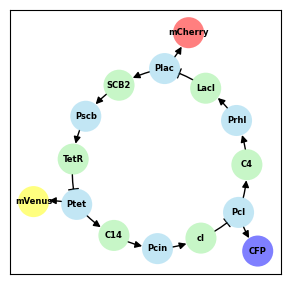

In [14]:
plt.figure(figsize=(3.5,3.5), dpi=100)
ext_rep.draw()

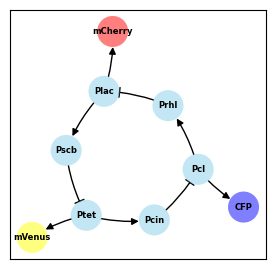

In [15]:
plt.figure(figsize=(3.3,3.3), dpi=100)
ext_rep.draw(contracted=True)

###Assay

In [16]:
metab = lc.SimulatedMetabolism('LOICA metab', biomass, growth_rate)

sample = lc.Sample(genetic_network=ext_rep, 
                metabolism=metab,
                media=media.id[0],
                strain=strain.id[0]
               )
assay = lc.Assay([sample], 
              n_measurements=500, 
              interval=0.25,
              name='Extended repressilator by Luiza',
              description='Simulated extended repressilator generated by LOICA',
              biomass_signal_id=biomass_signal.id[0]
             )
assay.run()

100%|██████████| 100.0/100 [00:07<00:00, 13.21it/s]


In [17]:
assay.upload(fj, study.id[0])

One or more assay already exists, type "yes" to replace them:yes


100%|██████████| 100.0/100 [00:01<00:00, 77.01it/s]


In [18]:
fig = fj.plot(study=study.id,
              vector=vector.id,
              strain=strain.id,
              media=media.id,
              normalize='Min/Max',
              subplots='Vector',
              markers='Signal',
              plot='Mean')  #change between Mean and Data

fig

100%|██████████| 100/100 [00:00<00:00, 438.48it/s]


In [19]:
fig = flapjack.layout_print(fig, width=3, height=2, font_size=6)
fig